In [1]:
import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.kernel_ridge import KernelRidge as KRR
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
import pandas as pd
import pickle
import elf
import mlc_func as mlcf
%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [20]:
def get_pred_uncertainty(baseline, systems_train, systems_test, which, strides = 0,  splits = [0.5], mean_train = 0):

    all_targets = []
    all_features = []
    for sysix, system in enumerate(systems_train):
        elfs = elf.utils.hdf5_to_elfs('../data/' + baseline + '/{}_processed.hdf5'.format(system), which)
        feat = np.concatenate([[e.value for e in e] for e in elfs], axis = 0)
        if isinstance(strides, list):
            feat = feat[::strides[sysix]]
        all_features.append(feat)
    feat_mb = np.concatenate(all_features)
    feat = np.concatenate(all_features)
    feat_mask = np.std(feat, axis = 0) > 1e-3
    feat = feat[:,feat_mask]
    scaler = StandardScaler(copy = True)
    scaler.fit(feat)
#     feat = scaler.transform(feat)
    
    for split in splits[:-1]:
        feat, _ = train_test_split(feat, test_size = split)
    X_train, X_test = train_test_split(feat, test_size = splits[-1])
    
    model = GPR(alpha=0.001)
    model.fit(X_train, np.zeros(len(X_train)))
    mean_train_computed = False
    if mean_train == 0:
        _, std_train = model.predict(X_train, return_std = True)
        mean_train = np.mean(std_train)
        mean_train_computed = True
    _, std_test = model.predict(X_test, return_std = True)
    
    
    all_features = []
    for system in systems_test:
        elfs = elf.utils.hdf5_to_elfs('../data/' + baseline + '/{}_processed.hdf5'.format(system), which)
        ext_feat = np.concatenate([[e.value for e in e] for e in elfs], axis = 0 )
        all_features.append(ext_feat)
    ext_feat = np.concatenate(all_features)
    ext_feat = ext_feat[:,feat_mask]
#     ext_feat = scaler.transform(ext_feat)
    print(np.std(ext_feat, axis = 0))
    print(np.mean(ext_feat, axis = 0))
    extended = np.zeros_like(ext_feat)
    extended[-len(ext_feat):] = ext_feat

    for split in splits[:-1]:
        extended, _ = train_test_split(extended, test_size = split)
    _, extended = train_test_split(extended, test_size = splits[-1])
    
    ext_feat = extended[np.sum(np.abs(extended), axis = -1) > 0] 

    _, std_ext = model.predict(ext_feat, return_std = True)
    std_ext /= mean_train
    
    return std_ext, mean_train

In [21]:
which = 'o'
splits = [0.5]
std_ext_mb, mean_train = get_pred_uncertainty('PBE/sz/basis_nocore_elf.json_processed',['monomers','dimers','trimers'],
                                              ['128'],
            which, strides = [1,1,1], splits = splits)

std_ext_emb, _ = get_pred_uncertainty('PBE/sz/basis_nocore_elf.json_processed',['16'],
                                   ['128'],which, strides = [16], splits = splits)


std_ext_64, _ = get_pred_uncertainty('PBE/sz/basis_nocore_elf.json_processed',['128'],
                                   ['128'],which, strides = [1,1,1,1], splits = [0.5])

std_ext_ghost, _ = get_pred_uncertainty('PBE/sz/basis_nocore_elf.json_processed',['16_ghost'],
                                   ['128'],which, strides = [16], splits = splits)

{'r_o_o': 1.0, 'r_i_o': 0.0, 'r_i_h': 0.0, 'r_o_h': 1.5, 'n_rad_o': 2, 'n_rad_h': 2, 'n_l_o': 3, 'n_l_h': 2, 'gamma_o': 0, 'gamma_h': 0, 'alignment': 'elf'}
{'r_o_o': 1.0, 'r_i_o': 0.0, 'r_i_h': 0.0, 'r_o_h': 1.5, 'n_rad_o': 2, 'n_rad_h': 2, 'n_l_o': 3, 'n_l_h': 2, 'gamma_o': 0, 'gamma_h': 0, 'alignment': 'elf'}
{'r_o_o': 1.0, 'r_i_o': 0.0, 'r_i_h': 0.0, 'r_o_h': 1.5, 'n_rad_o': 2, 'n_rad_h': 2, 'n_l_o': 3, 'n_l_h': 2, 'gamma_o': 0, 'gamma_h': 0, 'alignment': 'elf'}
{'r_o_o': 1.0, 'r_i_o': 0.0, 'r_i_h': 0.0, 'r_o_h': 1.5, 'n_rad_o': 2, 'n_rad_h': 2, 'n_l_o': 3, 'n_l_h': 2, 'gamma_o': 0, 'gamma_h': 0, 'alignment': 'elf'}
[1.27752837 1.06157206 2.42776589 6.21445106 5.66672974 2.83076707
 2.62534797 0.44685803 1.29281389 1.21926887 2.95057778 9.20110462
 8.15094637 3.31605831 4.02099267]
[ 2.36947504e+02  3.72941357e+00 -5.61314145e-02  1.60343879e-01
 -7.70357159e-01  1.08462962e-02  7.88182361e-01  9.38217351e+01
  2.33432904e+00  1.09092498e+01 -7.96588366e-01  2.59184563e-01
 -3.8866

Text(0.5,1,'Prediction uncertainty on liquid(64) set (Oxygen)')

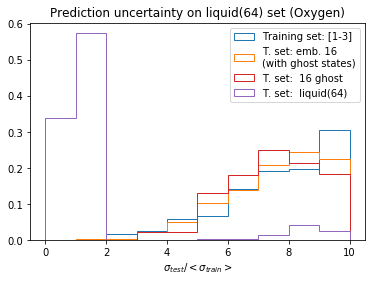

In [15]:
# hist(std_test ,density=True, range= (0,10), histtype= 'step', label = 'Training set: 1-3')
hist(std_ext_mb,color = 'C0', density = True,  range= (0,10), histtype= 'step', label = 'Training set: [1-3]')
hist(std_ext_emb,color = 'C1', density = True,  range= (0,10), histtype= 'step', label = 'T. set: emb. 16 \n(with ghost states)')
hist(std_ext_ghost,color = 'C3', density = True,  range= (0,10), histtype= 'step', label = 'T. set:  16 ghost ')
hist(std_ext_64,color = 'C4', density = True,  range= (0,10), histtype= 'step', label = 'T. set:  liquid(64)')
legend()
xlabel('$\sigma_{test}/ < \sigma_{train} > $')
title('Prediction uncertainty on liquid(64) set (Oxygen)')
# savefig('std_analysis_elf_hexembedded_O.pdf')
# savefig('std_analysis_elf_hexembedded_O.eps')

In [91]:
which = 'h'
splits = [0.6, 0.5]
std_ext_mb, mean_train = get_pred_uncertainty('revPBE',['monomers','dimers','trimers'],['64'],
                                  which, strides = [1,1,1], splits = splits)

std_ext_emb, _ = get_pred_uncertainty('revPBE',['monomers','dimers','trimers','hexamers_embedded_ghost'],
                                   ['64'],which, strides = [1,1,1,12], splits = splits, mean_train = mean_train)

std_ext_64, _ = get_pred_uncertainty('revPBE',['monomers','dimers','trimers','64'],
                                   ['64'],which, strides = [1,1,1,1], splits = splits, mean_train = mean_train)

{'r_o_o': 0.9, 'r_i_o': 0.05, 'n_rad_o': 2, 'n_l_o': 3, 'gamma_o': 0, 'r_i_h': 0.0, 'r_o_h': 1.35, 'n_rad_h': 2, 'n_l_h': 2, 'gamma_h': 0}
{'r_o_o': 0.9, 'r_i_o': 0.05, 'n_rad_o': 2, 'n_l_o': 3, 'gamma_o': 0, 'r_i_h': 0.0, 'r_o_h': 1.35, 'n_rad_h': 2, 'n_l_h': 2, 'gamma_h': 0}
{'r_o_o': 0.9, 'r_i_o': 0.05, 'n_rad_o': 2, 'n_l_o': 3, 'gamma_o': 0, 'r_i_h': 0.0, 'r_o_h': 1.35, 'n_rad_h': 2, 'n_l_h': 2, 'gamma_h': 0}
{'r_o_o': 0.9, 'r_i_o': 0.05, 'n_rad_o': 2, 'n_l_o': 3, 'gamma_o': 0, 'r_i_h': 0.0, 'r_o_h': 1.35, 'n_rad_h': 2, 'n_l_h': 2, 'gamma_h': 0}
{'r_o_o': 0.9, 'r_i_o': 0.05, 'n_rad_o': 2, 'n_l_o': 3, 'gamma_o': 0, 'r_i_h': 0.0, 'r_o_h': 1.35, 'n_rad_h': 2, 'n_l_h': 2, 'gamma_h': 0}
{'r_o_o': 0.9, 'r_i_o': 0.05, 'n_rad_o': 2, 'n_l_o': 3, 'gamma_o': 0, 'r_i_h': 0.0, 'r_o_h': 1.35, 'n_rad_h': 2, 'n_l_h': 2, 'gamma_h': 0}
{'r_o_o': 0.9, 'r_i_o': 0.05, 'n_rad_o': 2, 'n_l_o': 3, 'gamma_o': 0, 'r_i_h': 0.0, 'r_o_h': 1.35, 'n_rad_h': 2, 'n_l_h': 2, 'gamma_h': 0}
{'r_o_o': 0.9, 'r_i_o': 0.0

/home/sebastian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


{'r_o_o': 0.9, 'r_i_o': 0.05, 'n_rad_o': 2, 'n_l_o': 3, 'gamma_o': 0, 'r_i_h': 0.0, 'r_o_h': 1.35, 'n_rad_h': 2, 'n_l_h': 2, 'gamma_h': 0}
{'r_o_o': 0.9, 'r_i_o': 0.05, 'n_rad_o': 2, 'n_l_o': 3, 'gamma_o': 0, 'r_i_h': 0.0, 'r_o_h': 1.35, 'n_rad_h': 2, 'n_l_h': 2, 'gamma_h': 0}
{'r_o_o': 0.9, 'r_i_o': 0.05, 'n_rad_o': 2, 'n_l_o': 3, 'gamma_o': 0, 'r_i_h': 0.0, 'r_o_h': 1.35, 'n_rad_h': 2, 'n_l_h': 2, 'gamma_h': 0}
{'r_o_o': 0.9, 'r_i_o': 0.05, 'n_rad_o': 2, 'n_l_o': 3, 'gamma_o': 0, 'r_i_h': 0.0, 'r_o_h': 1.35, 'n_rad_h': 2, 'n_l_h': 2, 'gamma_h': 0}
{'r_o_o': 0.9, 'r_i_o': 0.05, 'n_rad_o': 2, 'n_l_o': 3, 'gamma_o': 0, 'r_i_h': 0.0, 'r_o_h': 1.35, 'n_rad_h': 2, 'n_l_h': 2, 'gamma_h': 0}
{'r_o_o': 0.9, 'r_i_o': 0.05, 'n_rad_o': 2, 'n_l_o': 3, 'gamma_o': 0, 'r_i_h': 0.0, 'r_o_h': 1.35, 'n_rad_h': 2, 'n_l_h': 2, 'gamma_h': 0}


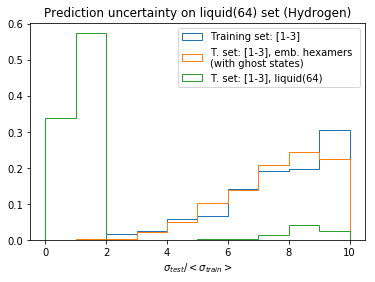

In [16]:
# hist(std_test ,density=True, range= (0,10), histtype= 'step', label = 'Training set: 1-3')
hist(std_ext_mb,color = 'C0', density = True,  range= (0,10), histtype= 'step', label = 'Training set: [1-3]')
hist(std_ext_emb,color = 'C1', density = True,  range= (0,10), histtype= 'step', label = 'T. set: [1-3], emb. hexamers \n(with ghost states)')
hist(std_ext_64,color = 'C2', density = True,  range= (0,10), histtype= 'step', label = 'T. set: [1-3], liquid(64)')
legend()
xlabel('$\sigma_{test}/ < \sigma_{train} > $')
title('Prediction uncertainty on liquid(64) set (Hydrogen)')
savefig('std_analysis_elf_hexembedded_H.pdf')
savefig('std_analysis_elf_hexembedded_H.eps')